In [ ]:
import json
import xarray as xr
import rioxarray
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cf
from matplotlib import pyplot as plt
import matplotlib as mpl
from pathlib import Path
from fiweps.util import coordutil as co
from fiweps.util import regridutils as rgrd

## Configuration and prep

### Directories and files

In [ ]:
configdir = Path("../config/dscale/")

with open(configdir / "domains_03_extent.json") as src:
    extent = json.load(src)
extent

{'d01': {'west': 161, 'east': -108, 'north': 76, 'south': 50},
 'd02': {'west': -178, 'east': -128, 'north': 72, 'south': 55}}

In [ ]:
co.deg180_360(extent['d01']['east'])

252

In [ ]:
datadirERA = Path("/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/")
borealmaskdir = Path("/Volumes/FIBOREAL/fiweps_data/GIS/raster_masks/era5_boreal_tundra_mask.nc")


In [ ]:
julysnowfiles = sorted(list(datadirERA.glob('*07.nc')))
junesnowfiles = sorted(list(datadirERA.glob('*06.nc')))
aprilsnowfiles = sorted(list(datadirERA.glob('*04.nc')))
allsnowfiles  = sorted(list(datadirERA.glob('*.nc')))
nonwintersnowfiles  = sorted(list(datadirERA.glob('*0[4-9].nc')))
nonwintersnowfiles

[PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1959_04.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1959_05.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1959_06.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1959_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1959_08.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1959_09.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1960_04.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1960_05.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysi

In [ ]:
cmap = plt.get_cmap('Blues', 5)

### Helper functions

In [ ]:
def get_2Dtemplate(ds, roimask_in=None):
    template_data = np.ones((len(ds.latitude), len(ds.longitude)))
    template_lats = ds.latitude
    template_lons = ds.longitude
    templateDS = xr.DataArray(template_data, 
        coords=[template_lats, template_lons], 
        dims=["latitude", "longitude"])
    if roimask_in is not None:
        templateDS = templateDS.where(roimask_in==1)
    return templateDS

def get_subsetted_array(ds, extent):
    return ds.sel(
    latitude=slice(extent['d01']['north'], extent['d01']['south']),
    longitude=slice(co.deg180_360(extent['d01']['west']), co.deg180_360(extent['d01']['east']))
    )

### Get boreal mask

In [ ]:
roimask_in = rgrd.get_mask().boreal_tundra_mask
roimask_in

<xarray.DataArray 'boreal_tundra_mask' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=int8]
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    grid_mapping:  crs
    description:   Location of boreal forest or tundra

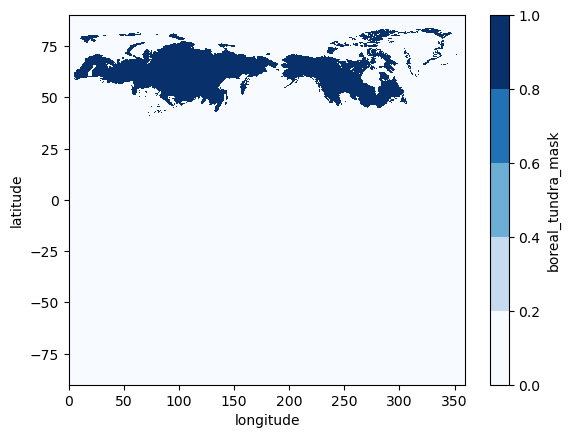

In [ ]:
roimask_in.plot(cmap=cmap)

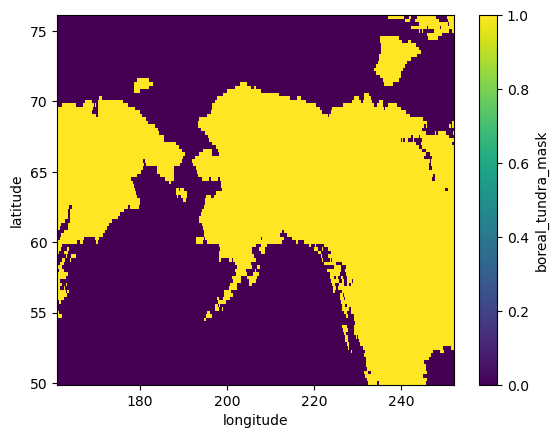

In [ ]:
get_subsetted_array(roimask_in, extent).plot()

In [ ]:
roimask_in

<xarray.DataArray 'boreal_tundra_mask' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=int8]
Coordinates:
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
Attributes:
    grid_mapping:  crs
    description:   Location of boreal forest or tundra

## make glacier mask

We'll make one glacier mask for each threshold and each year, from the first July dataset of every year. Since summer and winter are flipped between heispheres, we'll only do this for our boreal/Arctic area of interest. 

In [ ]:
thresholds = np.arange(0.5, 2.0, 0.5)        # look at 1m ... 6m 
outdir = Path("/Users/christine/Projects/dyndowndata/working")


In [ ]:
thresholds

array([0.5, 1. , 1.5])

Test glacier masks already in the directory.

In [ ]:
julysnowfiles

[PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1959_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1960_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1961_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1962_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1963_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1964_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1965_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysis-era5-single-levels/sd/reanalysis-era5-single-levels_sd_1966_07.nc'),
 PosixPath('/Volumes/FIBOREAL/data/cds/reanalysi

In [ ]:
sorted(list(outdir.glob("*glaciermask*.nc")))

[PosixPath('/Users/christine/Projects/dyndowndata/working/glaciermask_thresh_0.5m.nc'),
 PosixPath('/Users/christine/Projects/dyndowndata/working/glaciermask_thresh_0.5m_dilate1.nc'),
 PosixPath('/Users/christine/Projects/dyndowndata/working/glaciermask_thresh_0.5m_dilate2.nc'),
 PosixPath('/Users/christine/Projects/dyndowndata/working/glaciermask_thresh_0.5m_dilate3.nc'),
 PosixPath('/Users/christine/Projects/dyndowndata/working/glaciermask_thresh_1.0m.nc'),
 PosixPath('/Users/christine/Projects/dyndowndata/working/glaciermask_thresh_1.5m.nc'),
 PosixPath('/Users/christine/Projects/dyndowndata/working/glaciermask_thresh_2.0m.nc'),
 PosixPath('/Users/christine/Projects/dyndowndata/working/glaciermask_thresh_2.5m.nc'),
 PosixPath('/Users/christine/Projects/dyndowndata/working/glaciermask_thresh_3.0m.nc')]

### Make individual year / thresh glacier masks

In [ ]:
for thresh in thresholds:
    outpth = outdir / f"thresh_{thresh:.1f}m"
    outpth.mkdir(parents=True, exist_ok=True)
    print(f"Working on threshold = {thresh}, writing to {outpth}. ")
    for fpth in nonwintersnowfiles:
        # yr = fpth.stem[-7:-3]
        yrmth = fpth.stem[-7:]
        print(f"Working on {yrmth}")
        with xr.open_dataset(fpth, chunks='auto') as ds:
            sd_era5 = ds.sd.isel(time=0)
            templ = get_2Dtemplate(ds, roimask_in=roimask_in)
        templ = templ.where(sd_era5 > thresh)
        templ = rgrd.attach_basicmetadata(templ)
        templ = templ.rename("glaciermask")
        templ = templ.fillna(0)
        templ = templ.astype('int')
        templ.attrs['title'] = f"ERA5-gridded glacier mask for year/month={yrmth} and threshold={thresh} for snow water equiv"
        outfpth = outpth / f"glaciermask_{yrmth}.nc"
        templ.to_netcdf(outfpth, 
            engine='netcdf4', encoding={
            'glaciermask':{'zlib': True,'complevel': 2}})
        print(f"Wrote {outfpth}")
        
        
            

Working on threshold = 0.5, writing to /Users/christine/Projects/dyndowndata/working/thresh_0.5m. 
Working on 1959_04
Wrote /Users/christine/Projects/dyndowndata/working/thresh_0.5m/glaciermask_1959_04.nc
Working on 1959_05
Wrote /Users/christine/Projects/dyndowndata/working/thresh_0.5m/glaciermask_1959_05.nc
Working on 1959_06
Wrote /Users/christine/Projects/dyndowndata/working/thresh_0.5m/glaciermask_1959_06.nc
Working on 1959_07
Wrote /Users/christine/Projects/dyndowndata/working/thresh_0.5m/glaciermask_1959_07.nc
Working on 1959_08
Wrote /Users/christine/Projects/dyndowndata/working/thresh_0.5m/glaciermask_1959_08.nc
Working on 1959_09
Wrote /Users/christine/Projects/dyndowndata/working/thresh_0.5m/glaciermask_1959_09.nc
Working on 1960_04
Wrote /Users/christine/Projects/dyndowndata/working/thresh_0.5m/glaciermask_1960_04.nc
Working on 1960_05
Wrote /Users/christine/Projects/dyndowndata/working/thresh_0.5m/glaciermask_1960_05.nc
Working on 1960_06
Wrote /Users/christine/Projects/dy

### Make one glacier mask for each threshold

In [ ]:
f"thresh_{thresh:.1f}m/*.nc"

'thresh_3.0m/*.nc'

In [ ]:
workpth = outdir


for thresh in thresholds:
    print(f"Working on threshold = {thresh}")
    print(str(workpth / f"thresh_{thresh:.1f}m*.nc"))
    mfds = xr.open_mfdataset(str(workpth / f"thresh_{thresh:.1f}m/*.nc"), combine='nested', concat_dim='time') 
    combined = mfds.any(dim='time').glaciermask.astype(int)
    combined = rgrd.attach_basicmetadata(combined)
    combined = combined.drop_vars('crs')
    combined.attrs['title'] = f"ERA5-gridded glacier mask for threshold={thresh} for snow water equiv, years combined"
    combined.to_netcdf(workpth / f"glaciermask_thresh_{thresh:.1f}m.nc", 
        engine='netcdf4', encoding={
        'glaciermask':{'zlib': True,'complevel': 2}})


Working on threshold = 0.5
/Users/christine/Projects/dyndowndata/working/thresh_0.5m*.nc
Working on threshold = 1.0
/Users/christine/Projects/dyndowndata/working/thresh_1.0m*.nc
Working on threshold = 1.5
/Users/christine/Projects/dyndowndata/working/thresh_1.5m*.nc


0.5


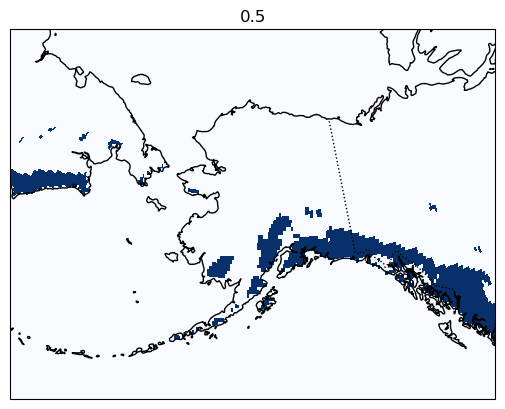

1.0


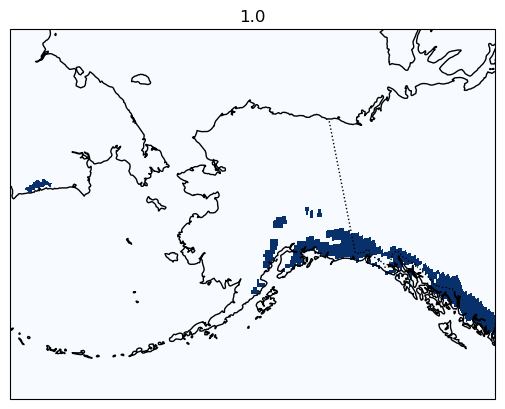

1.5


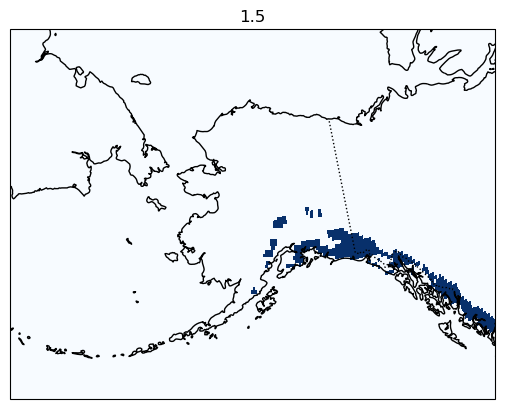

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))

for thresh in thresholds:
    print(thresh)
    ax = plt.axes(projection=projection)
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')
    with xr.open_dataarray(outdir / f"glaciermask_thresh_{str(thresh)}m.nc") as combined:
        combined.plot(
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
            ax=ax,
        )
    ax.set_title(f"{thresh}")
    plt.show()

In [ ]:
combined.drop_vars('crs')
combined

<xarray.DataArray 'glaciermask' (latitude: 721, longitude: 1440)>
[1038240 values with dtype=int64]
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    crs        object ...
Attributes:
    title:        ERA5-gridded glacier mask for threshold=3.0 for snow water ...
    institution:  International Arctic Research Center, UAF
    source:       Python, data file version  0.9
    author:       Chris Waigl cwaigl@alaska.edu 
    history:      2023-12-31 05:51:34.650093

glaciermask_thresh_0.5m


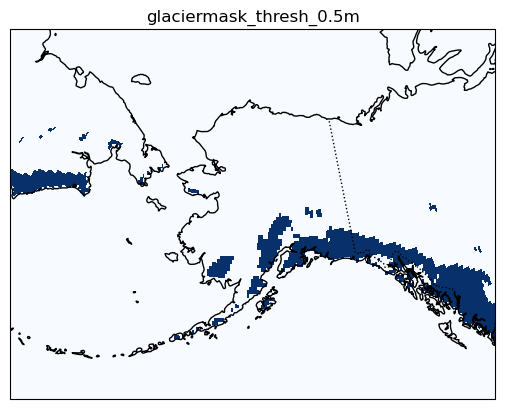

glaciermask_thresh_0.5m_dilate1


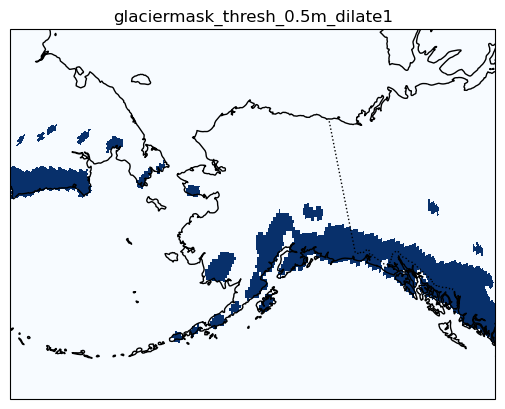

glaciermask_thresh_0.5m_dilate2


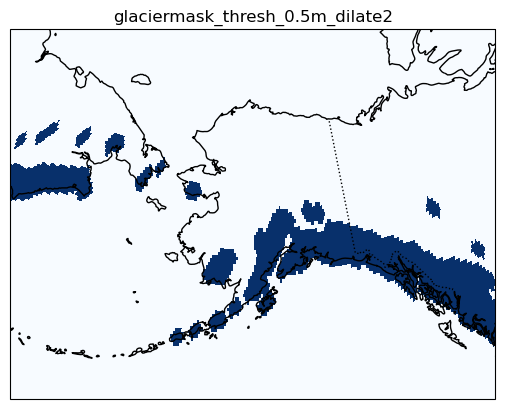

glaciermask_thresh_0.5m_dilate3


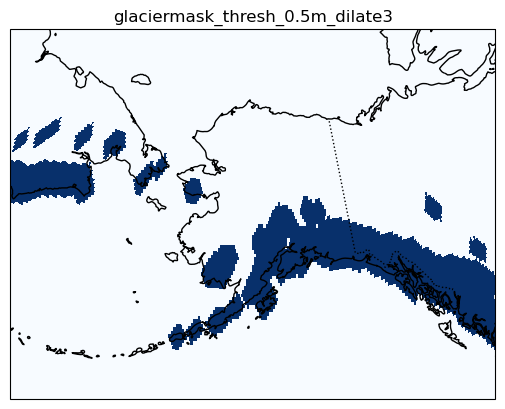

glaciermask_thresh_1.0m


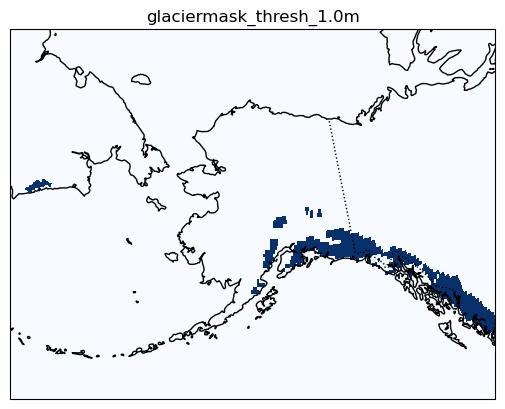

glaciermask_thresh_1.0m_dilate1


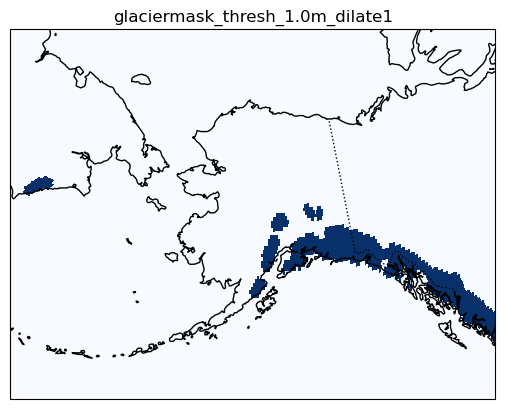

glaciermask_thresh_1.0m_dilate2


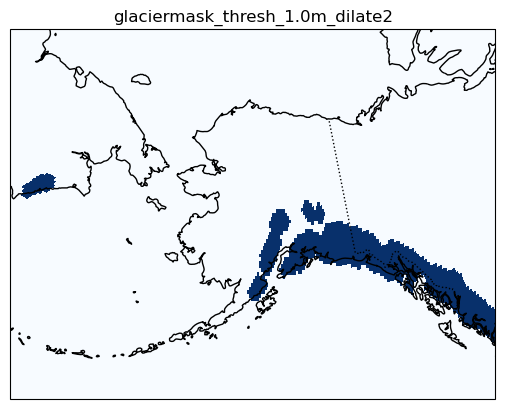

glaciermask_thresh_1.0m_dilate3


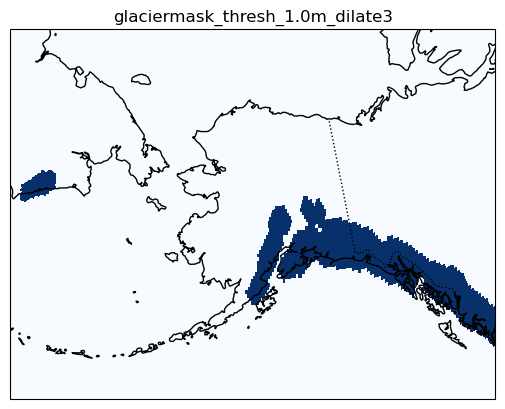

glaciermask_thresh_1.5m


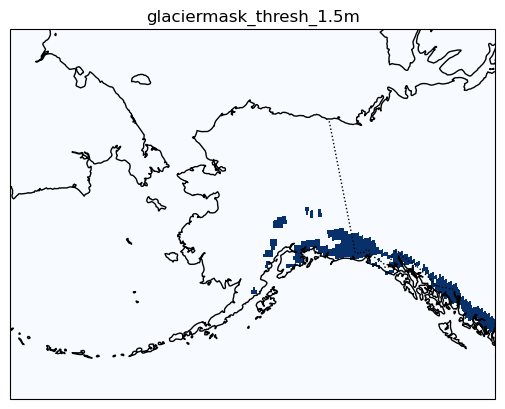

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))

for fp in sorted(list(outdir.glob("*glaciermask*.nc"))):
    print(fp.stem)
    ax = plt.axes(projection=projection)
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')
    with xr.open_dataarray(fp) as combined:
        combined.plot(
            cmap=cmap,
            transform=ccrs.PlateCarree(),
            add_colorbar=False,
            ax=ax,
        )
    ax.set_title(f"{fp.stem}")
    plt.show()



In [ ]:
combined.sum().data.item()

4814

## Make data series measuring SD (snow-water equivalent) in the glaciermask area 

In [ ]:
sumsnow = []

for thresh in thresholds:
    print(f"Working on threshold = {thresh}")
    newsnow = {}
    newsnow['threshold'] = int(thresh)
    with xr.open_dataarray(outdir / f"glaciermask_thresh_{int(thresh)}m.nc") as glaciermask:
        for fpth in julysnowfiles:
            yr = fpth.stem[-7:-3]
            try:
                newsnow['year'].append(int(yr))
            except KeyError:
                newsnow['year'] = [int(yr)]
            with xr.open_dataset(fpth, chunks='auto') as ds:
                july_sd_era5 = ds.sd.isel(time=0)
            july_sd_era5 = july_sd_era5.where(glaciermask==1)
            # global
            glaciersnow = july_sd_era5.sum(skipna=True).compute().data.item()
            try: 
                newsnow['globalglaciersnow'].append(glaciersnow)
            except KeyError:
                newsnow['globalglaciersnow'] = [glaciersnow]
            # subsetted to AK
            july_sd_era5 = get_subsetted_array(july_sd_era5, extent)
            glaciersnow = july_sd_era5.sum(skipna=True).compute().data.item()
            try: 
                newsnow['AKglaciersnow'].append(glaciersnow)
            except KeyError:
                newsnow['AKglaciersnow'] = [glaciersnow]
        fullcount = glaciermask.sum().data.item()
        newsnow['glacierpix_global'] = fullcount
        glaciermask_AK = get_subsetted_array(glaciermask, extent)
        AKcount = glaciermask_AK.sum().data.item()
        newsnow['glacierpix_AK'] = AKcount
        newsnow['AKglaciersnow'] = np.array(newsnow['AKglaciersnow'])
        newsnow['globalglaciersnow'] = np.array(newsnow['globalglaciersnow'])
        sumsnow.append(newsnow)


Working on threshold = 1.0
Working on threshold = 2.0
Working on threshold = 3.0
Working on threshold = 4.0
Working on threshold = 5.0
Working on threshold = 6.0


In [ ]:
len(sumsnow)

NameError: name 'sumsnow' is not defined

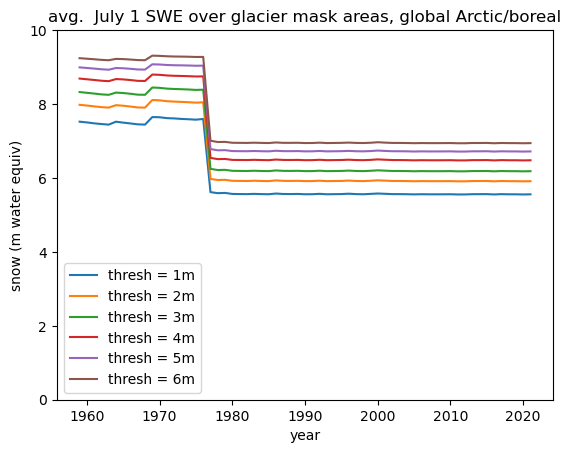

In [ ]:
for thresh in thresholds:
    data = sumsnow[int(thresh)-1]
    plt.plot(data['year'], data['globalglaciersnow']/data['glacierpix_global'], label=f"thresh = {int(thresh)}m")
    plt.legend()
    plt.ylabel("snow (m water equiv)")
    plt.xlabel("year")
    plt.title("avg.  July 1 SWE over glacier mask areas, global Arctic/boreal")
    plt.ylim((0,10))

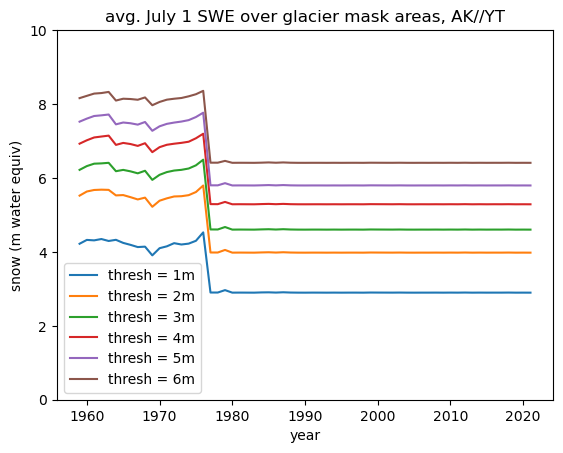

In [ ]:
for thresh in thresholds:
    data = sumsnow[int(thresh)-1]
    plt.plot(data['year'], data['AKglaciersnow']/data['glacierpix_AK'], label=f"thresh = {int(thresh)}m")
    plt.legend()
    plt.ylabel("snow (m water equiv)")
    plt.xlabel("year")
    plt.title("avg. July 1 SWE over glacier mask areas, AK//YT")
    plt.ylim((0,10))

Text(0.5, 0, 'threshold')

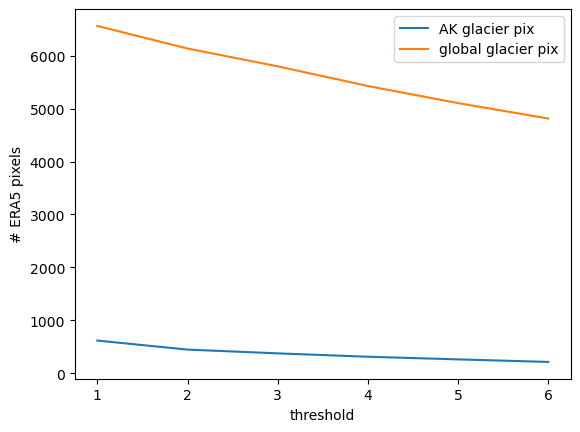

In [ ]:
glacierpix_AK = [item['glacierpix_AK'] for item in sumsnow]
glacierpix_global = [item['glacierpix_global'] for item in sumsnow]
plt.plot(thresholds, glacierpix_AK, label=f"AK glacier pix")
plt.plot(thresholds, glacierpix_global, label=f"global glacier pix")
plt.legend()
plt.ylabel("# ERA5 pixels")
plt.xlabel("threshold")


## Prototyping code area

In [ ]:
julysnowfiles[20].stem[-7:-3]

'1979'

In [ ]:
ds = xr.open_dataset(julysnowfiles[20], chunks='auto')
july_sd_era5 = ds.sd.isel(time=0)
#july_sd_era5_mean = ds.sd.mean(dim="time")
july_sd_era5.where(july_sd_era5 > 1)



<xarray.DataArray 'sd' (latitude: 721, longitude: 1440)>
dask.array<where, shape=(721, 1440), dtype=float32, chunksize=(253, 506), chunktype=numpy.ndarray>
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
    time       datetime64[ns] 1979-07-01
Attributes:
    units:          m of water equivalent
    long_name:      Snow depth
    standard_name:  lwe_thickness_of_surface_snow_amount

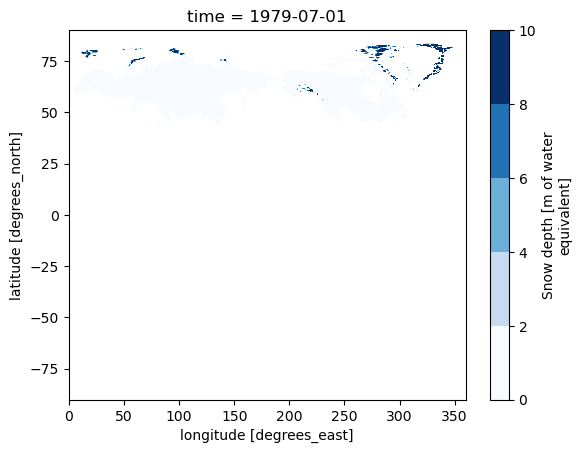

In [ ]:
july_sd_era5.where(roimask_in==1).plot(cmap=cmap)

/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/chris/mambaforge/envs/dyndowntools/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encou

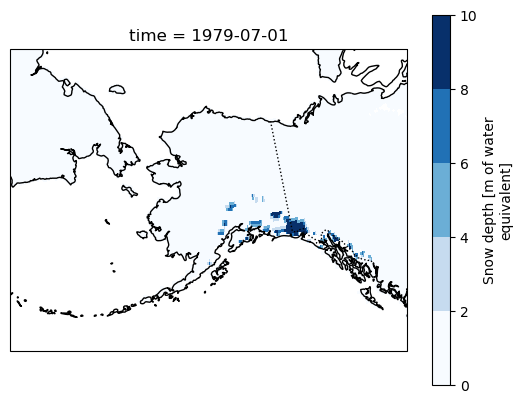

In [ ]:
projection = ccrs.AlbersEqualArea(
    central_longitude=-154.0, central_latitude=50.0, 
    standard_parallels=(55.0, 65.0))
ax = plt.axes(projection=projection)
ax.set_extent([-180, -130, 48, 75])
ax.coastlines()
ax.add_feature(cf.BORDERS, linestyle=':')
july_sd_era5.where(roimask_in==1).plot(
    cmap=cmap,
    transform=ccrs.PlateCarree(),
#    add_colorbar=False,
    ax=ax,
)


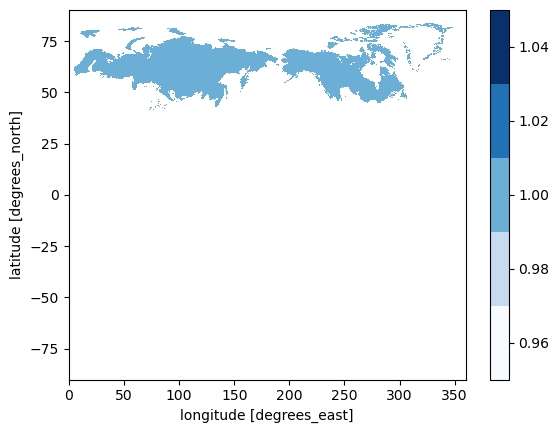

In [ ]:
templ = get_2Dtemplate(ds, roimask_in=roimask_in)
templ.plot(cmap=cmap)

In [ ]:
templ = templ.where(july_sd_era5 > 1)
#templ = rgrd.attach_basicmetadata(templ)
templ = templ.rename("glaciermask")
templ = templ.fillna(0)
templ = templ.astype('int')

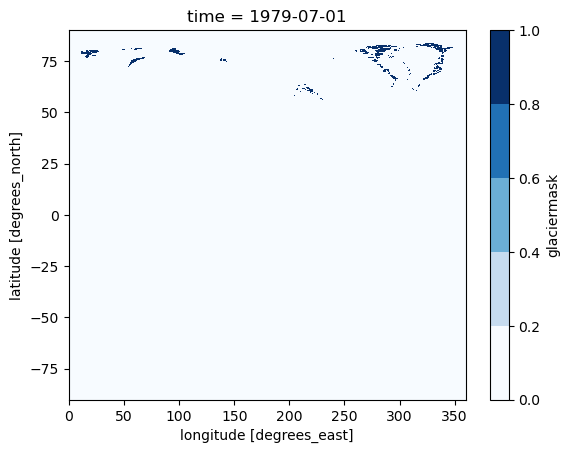

In [ ]:
templ.plot(cmap=cmap)

In [ ]:
rgrd.attach_basicmetadata(templ)

<xarray.DataArray 'glaciermask' (latitude: 721, longitude: 1440)>
dask.array<astype, shape=(721, 1440), dtype=int64, chunksize=(253, 506), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    time       datetime64[ns] 1979-07-01
    crs        <U1 ''
Attributes:
    title:        An ERA5-shaped dataset from the UAF FiWePs team
    institution:  International Arctic Research Center, UAF
    source:       Python, data file version  0.9
    author:       Chris Waigl cwaigl@alaska.edu 
    history:      2023-02-03 21:56:11.718039

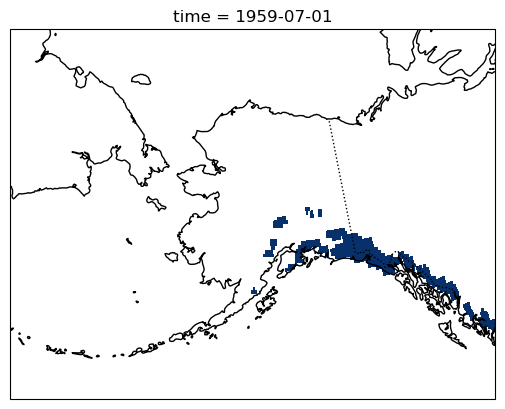

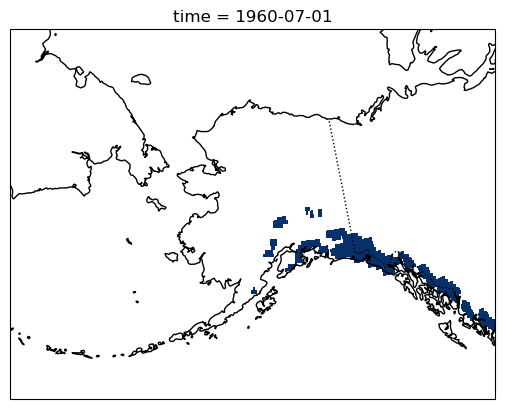

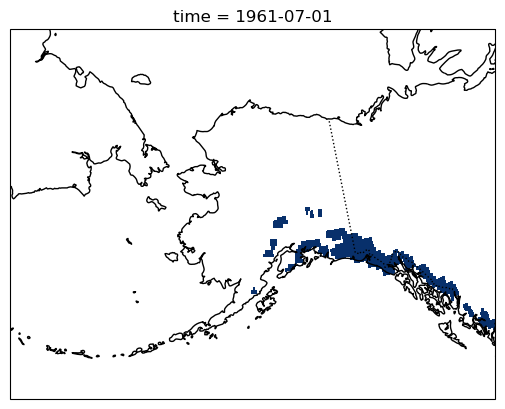

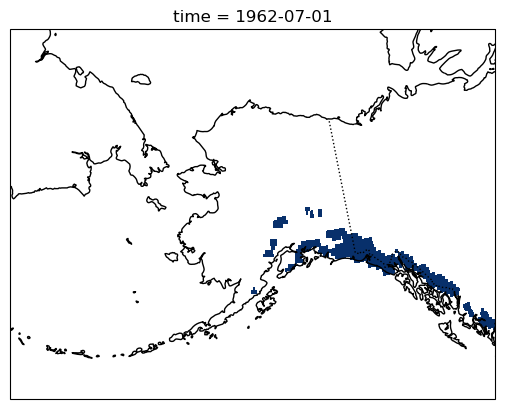

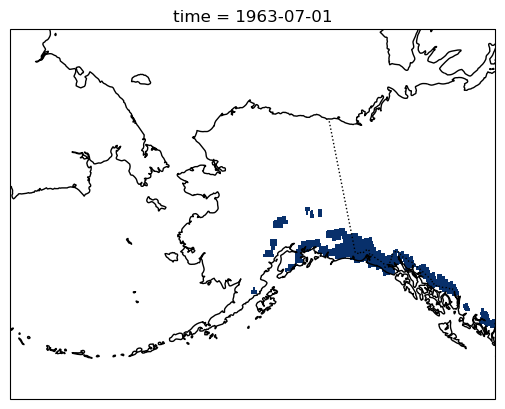

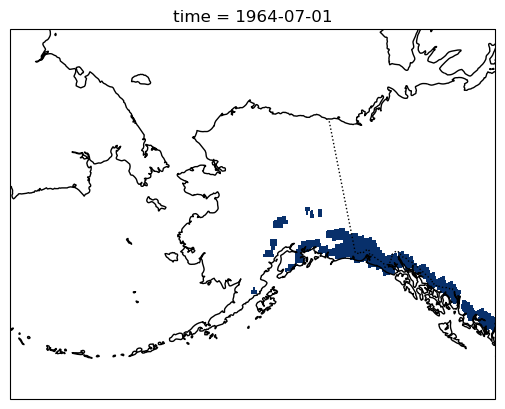

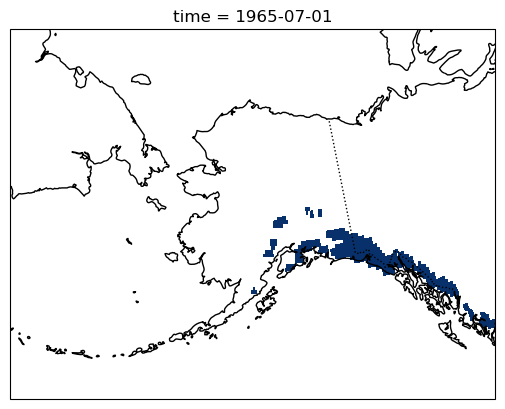

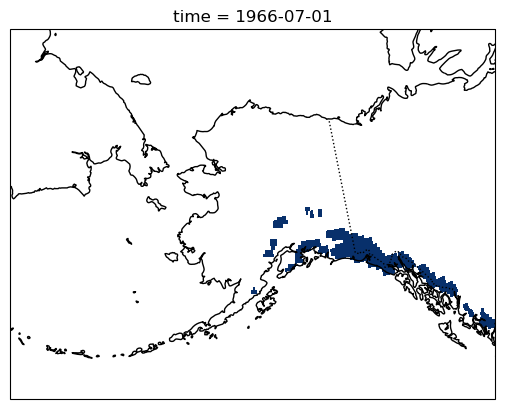

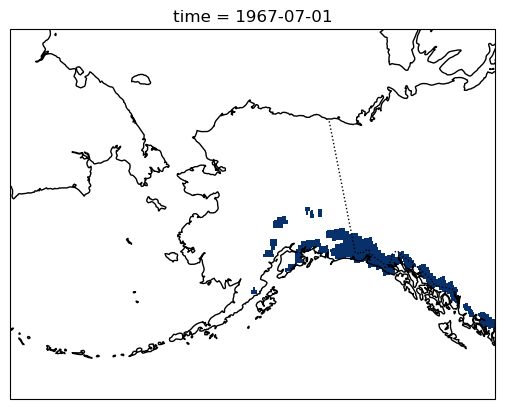

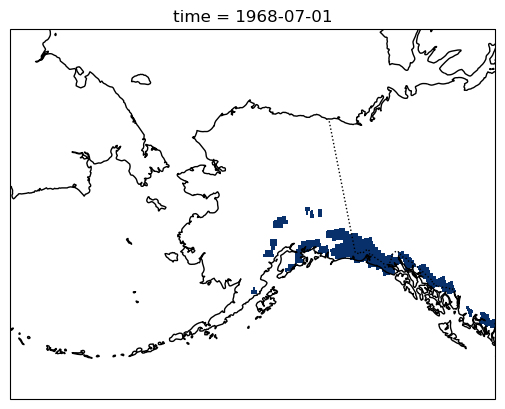

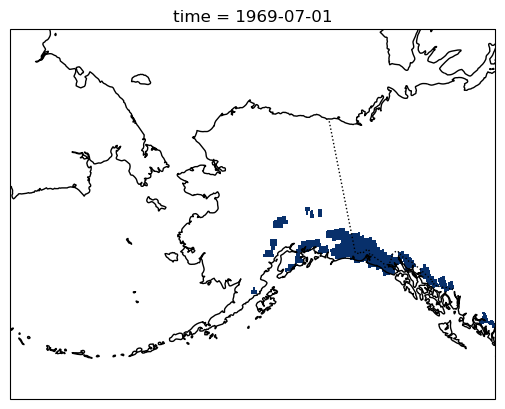

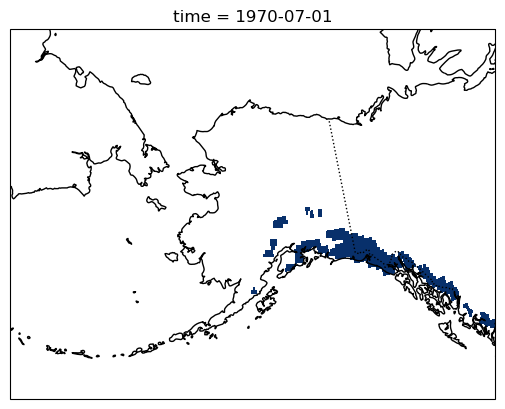

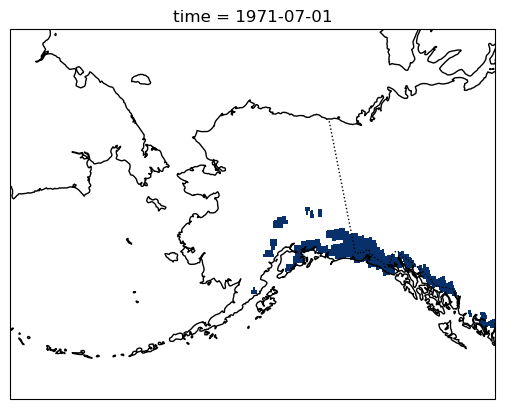

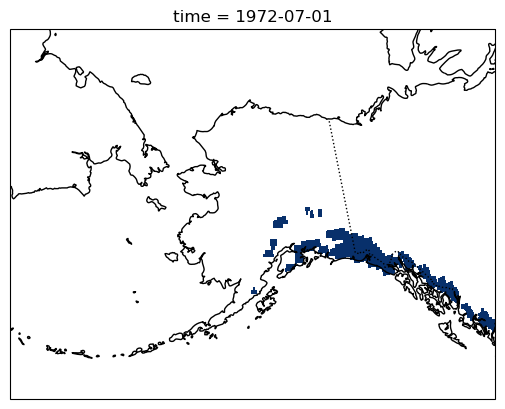

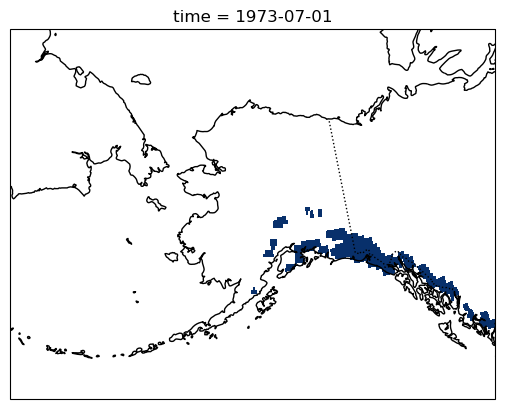

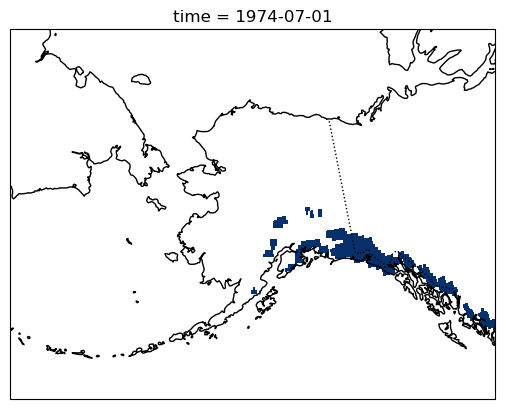

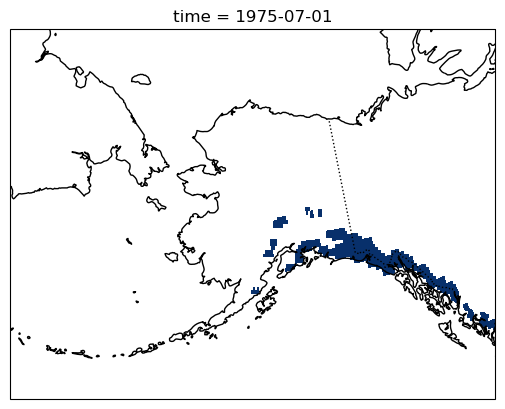

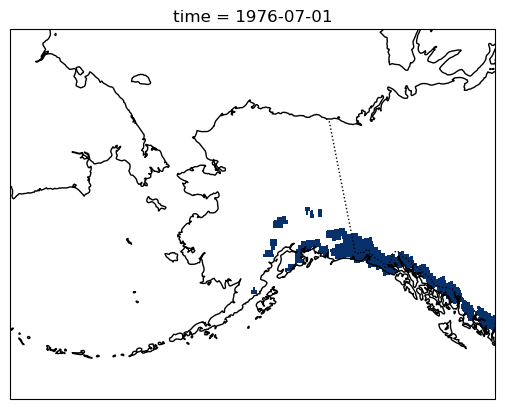

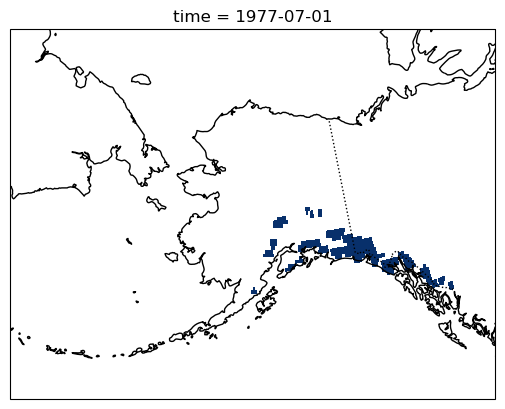

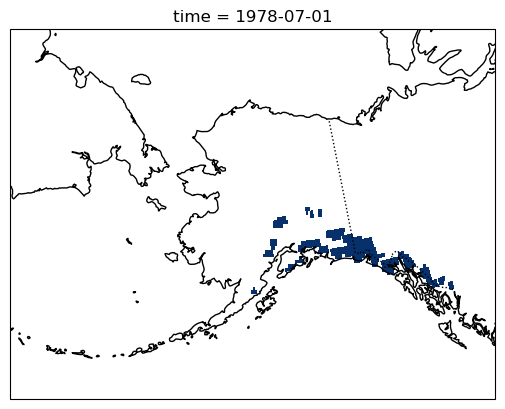

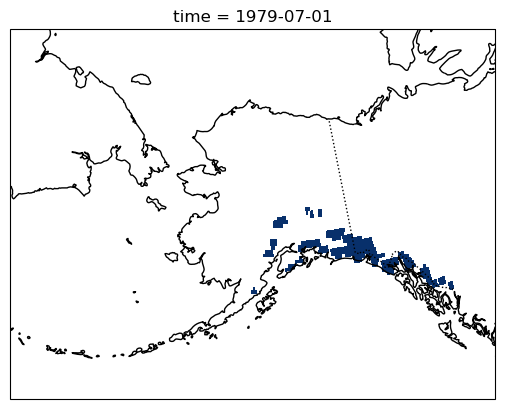

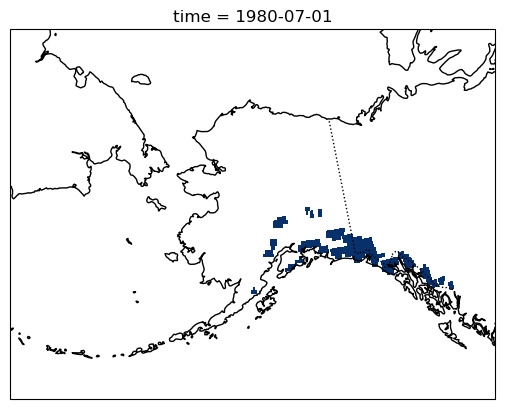

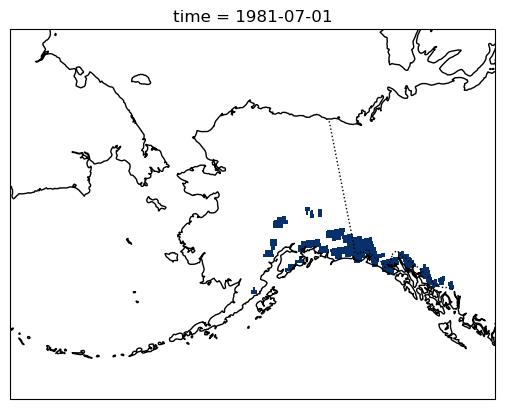

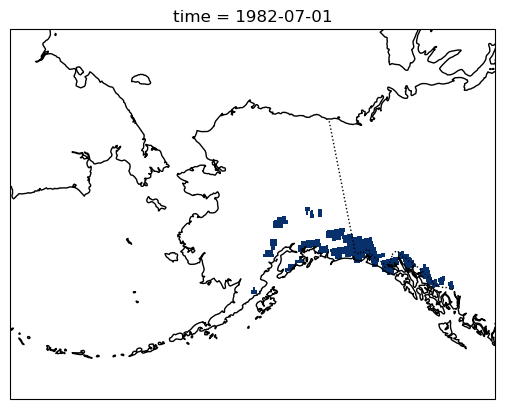

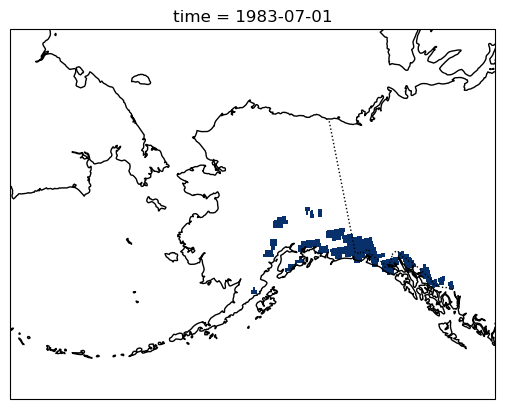

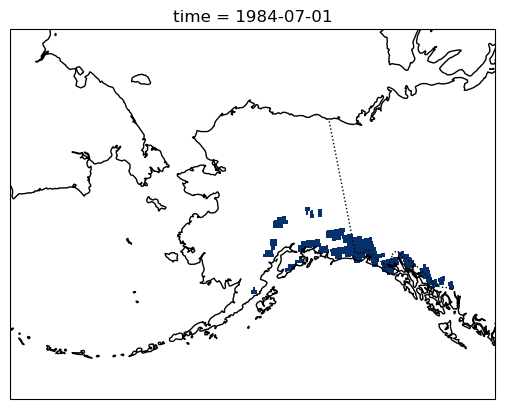

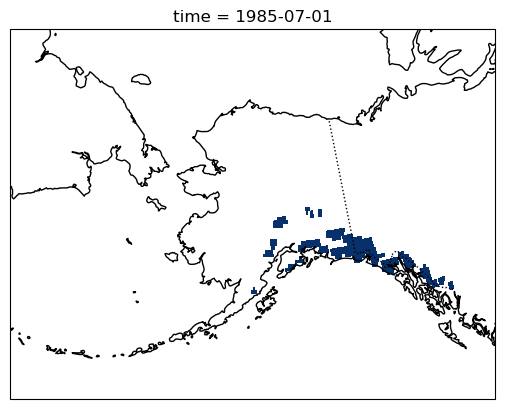

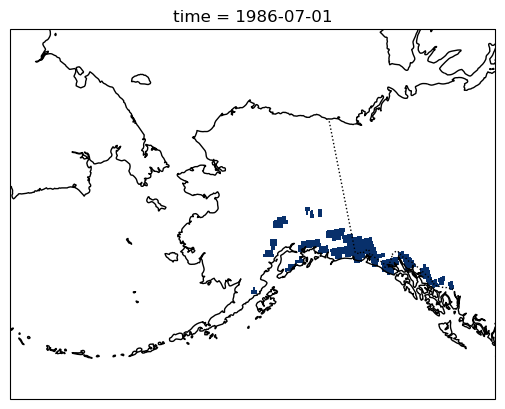

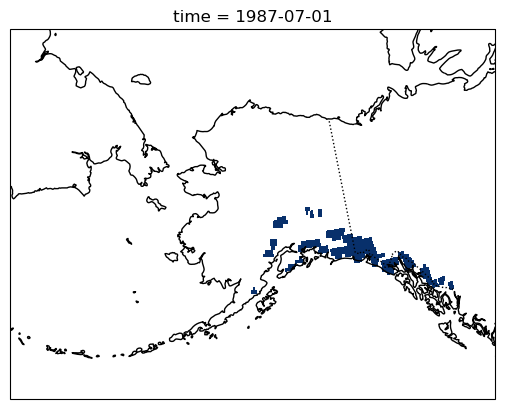

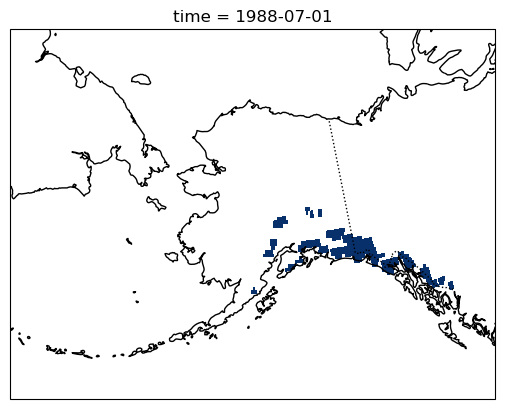

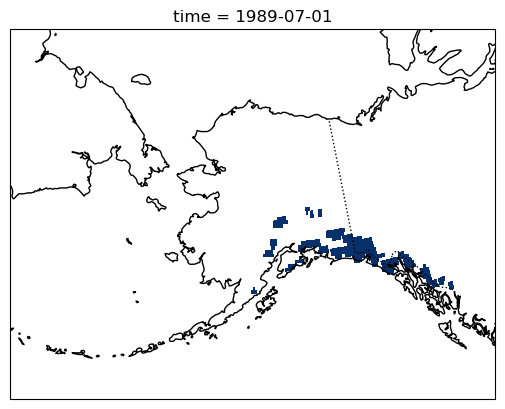

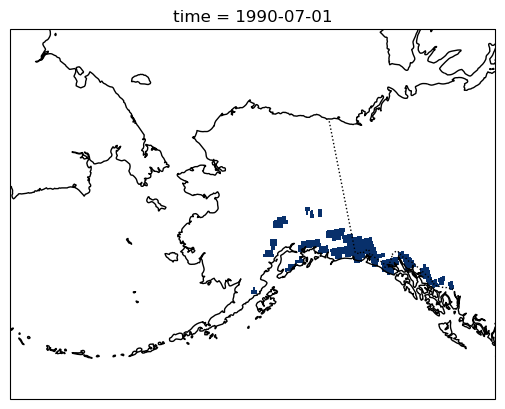

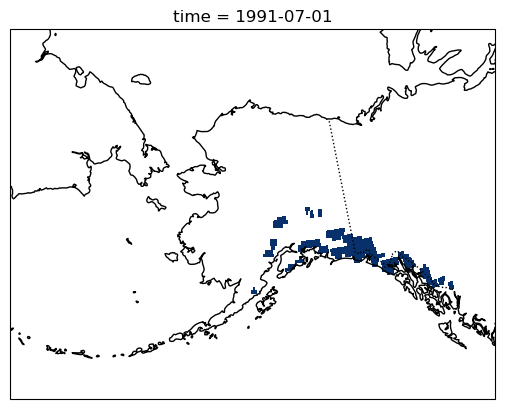

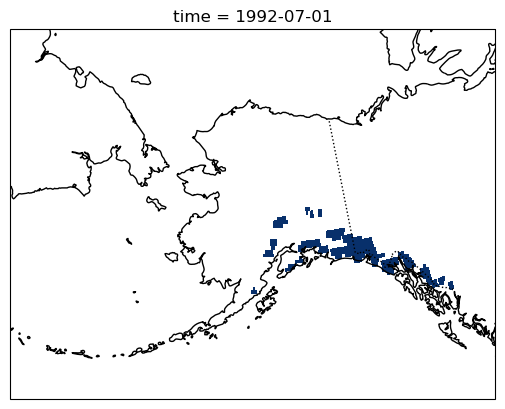

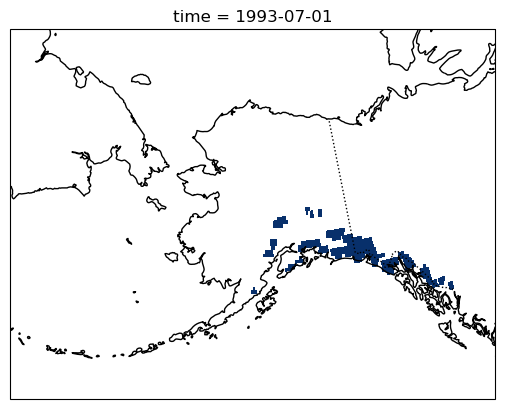

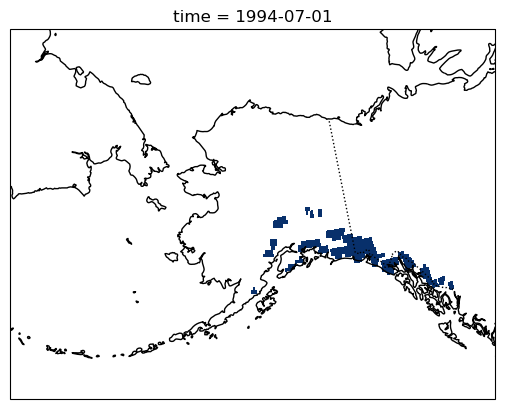

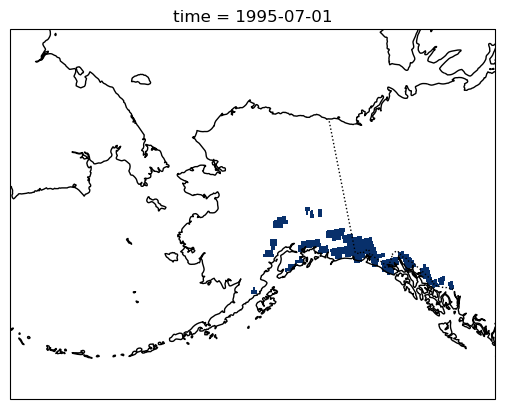

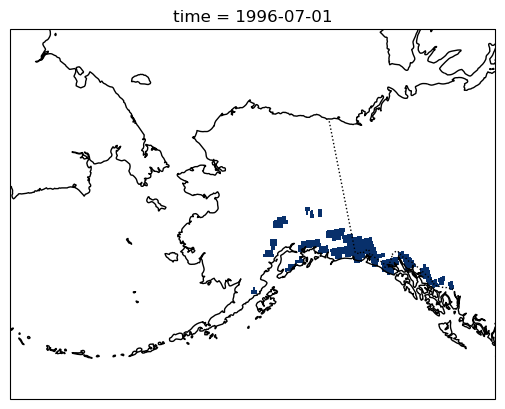

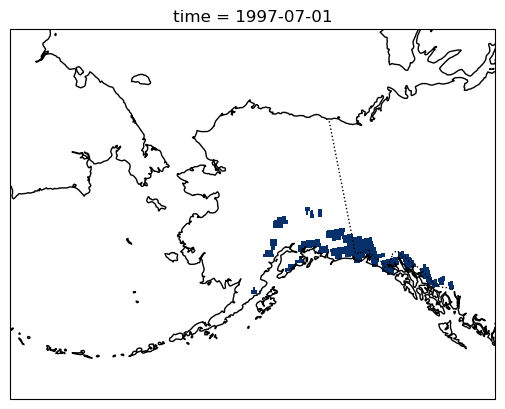

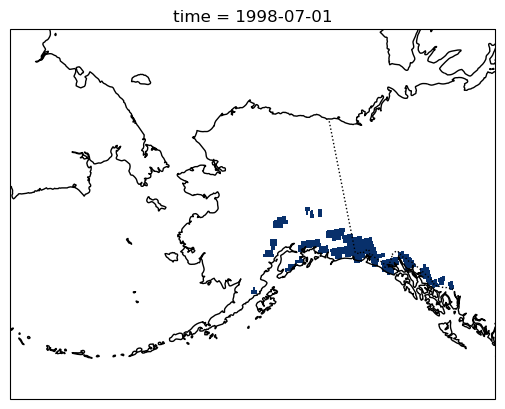

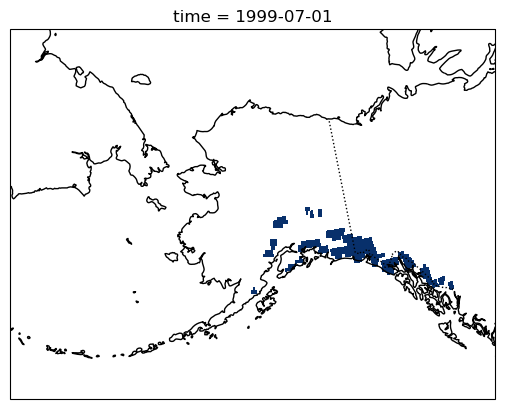

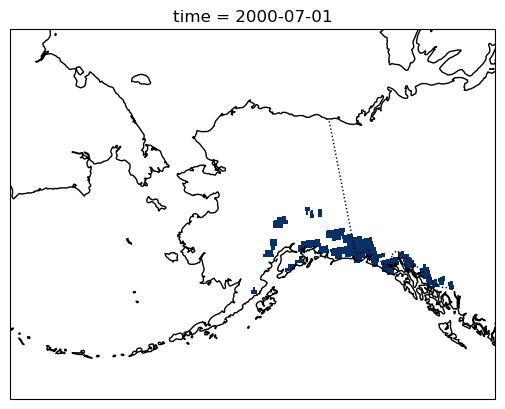

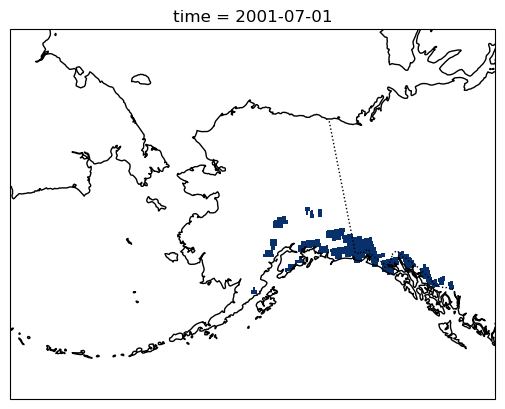

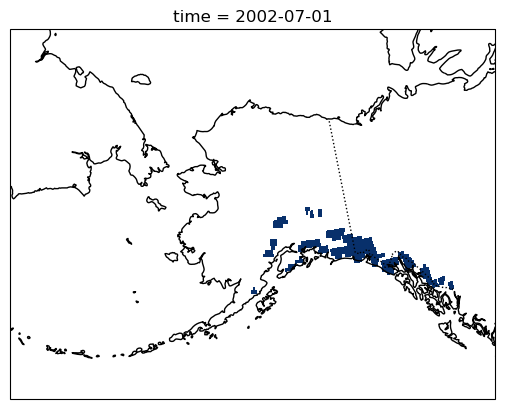

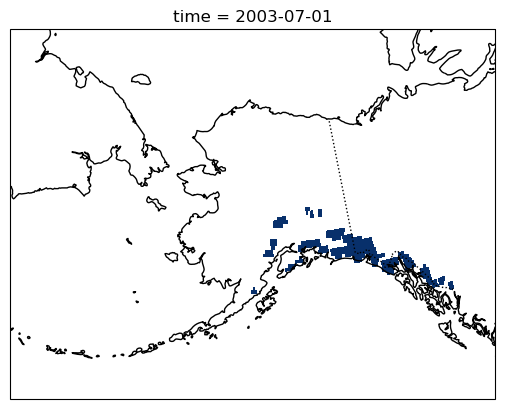

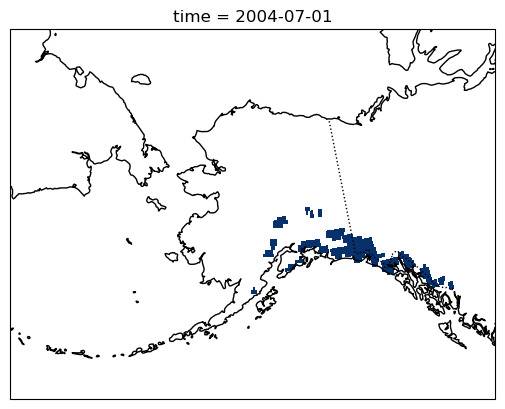

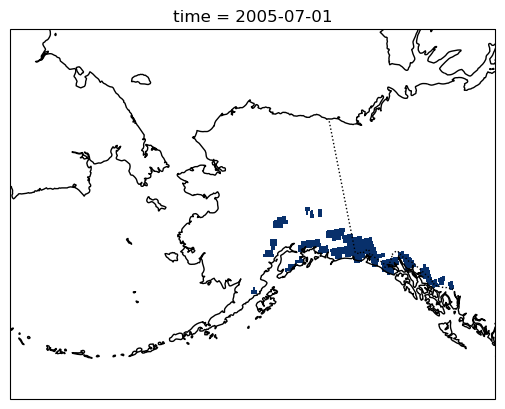

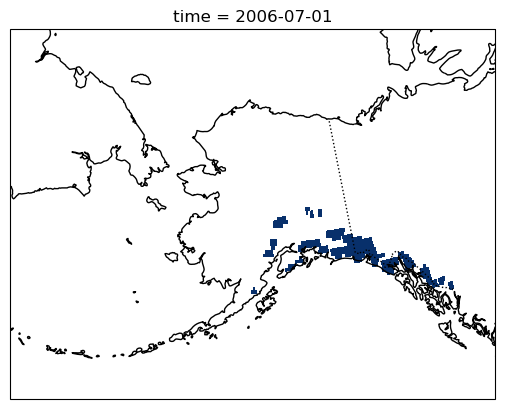

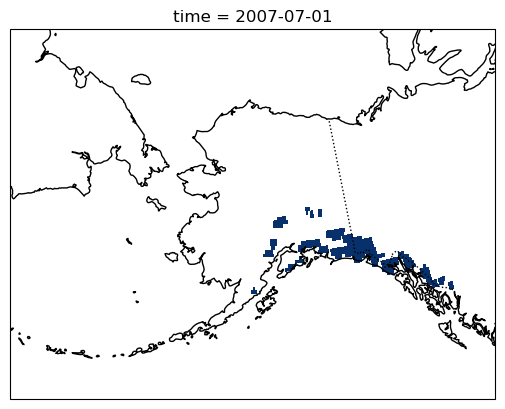

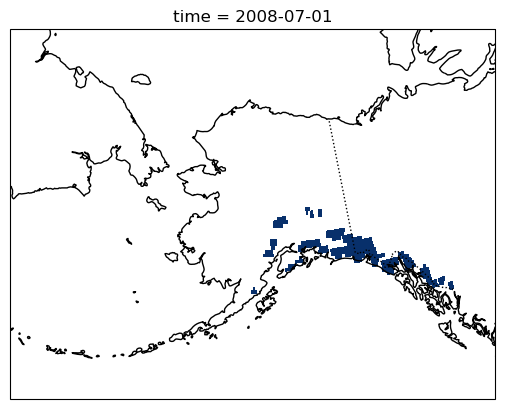

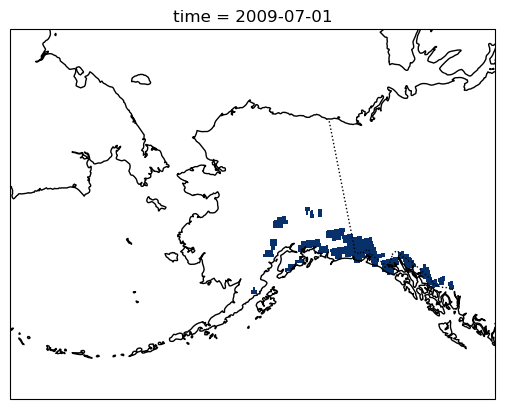

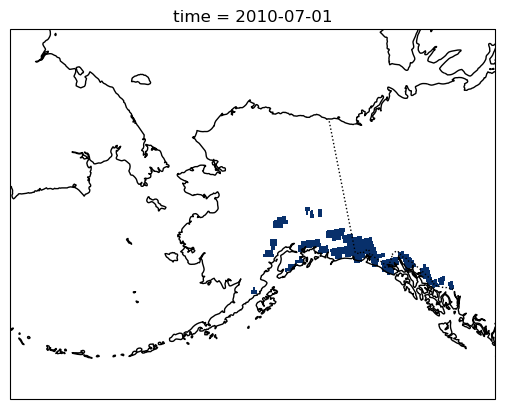

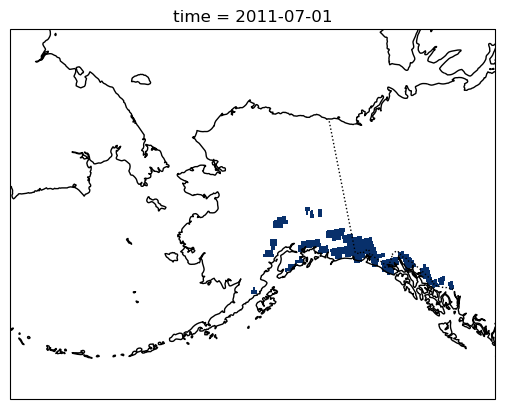

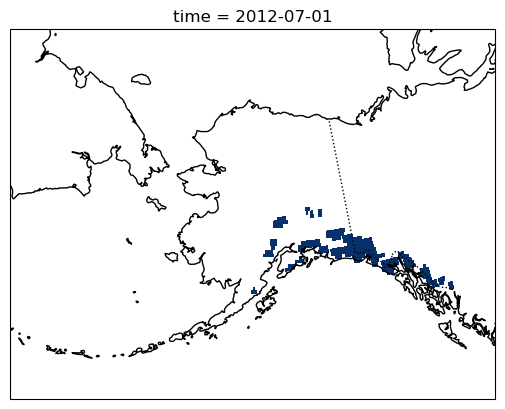

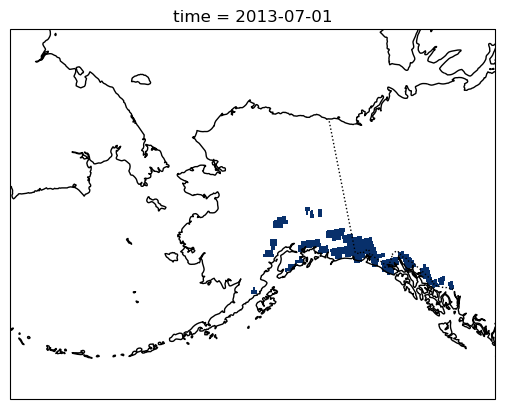

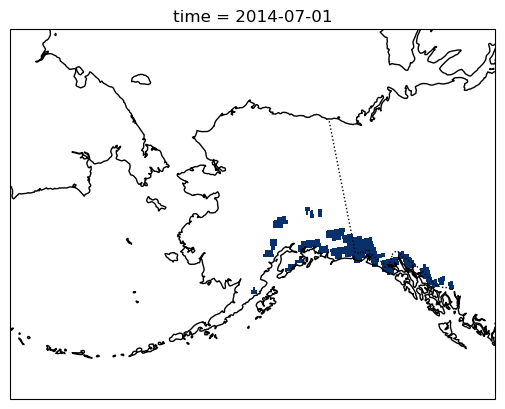

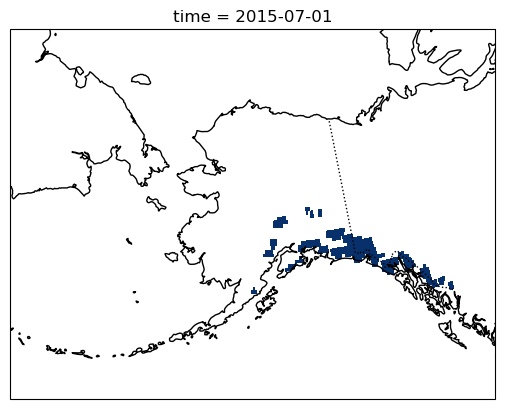

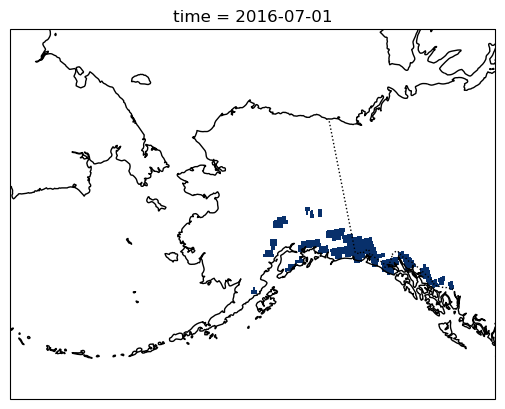

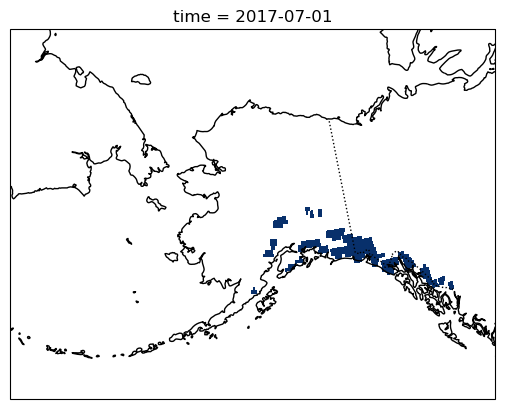

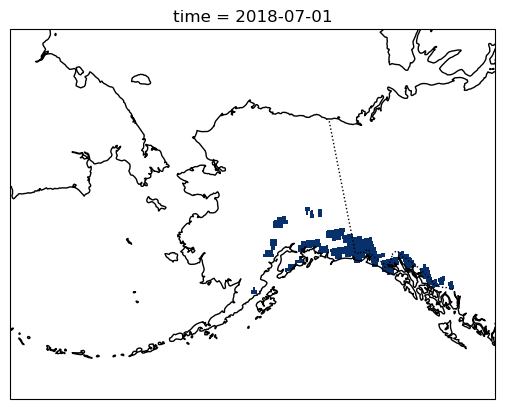

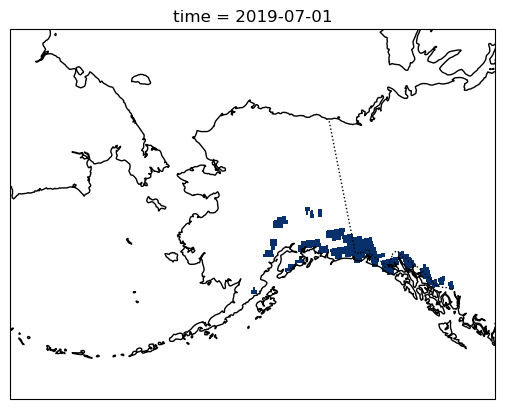

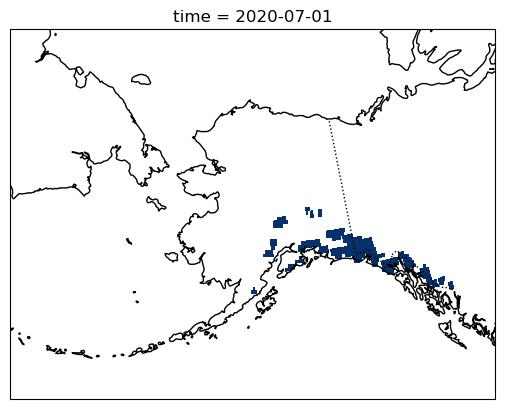

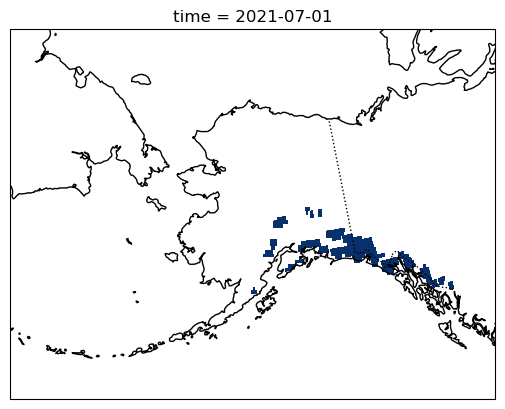

In [ ]:
thresh = 1.0

projection = ccrs.AlbersEqualArea(
central_longitude=-154.0, central_latitude=50.0, 
standard_parallels=(55.0, 65.0))

for pth in julysnowfiles[:]:
    ds = xr.open_dataset(pth, chunks='auto')
    july_sd_era5 = ds.sd.isel(time=0)
    templateDS = get_2Dtemplate(ds)
    templateDS = templateDS.where(july_sd_era5 > thresh)

    ax = plt.axes(projection=projection)
    ax.set_extent([-180, -130, 48, 75])
    ax.coastlines()
    ax.add_feature(cf.BORDERS, linestyle=':')
    templateDS.plot(
#    july_sd_era5.plot(
    cmap=plt.get_cmap('Blues', 2),
    transform=ccrs.PlateCarree(),
    add_colorbar=False,
    ax=ax,
    )
    plt.show()

In [ ]:
templateDS = templ

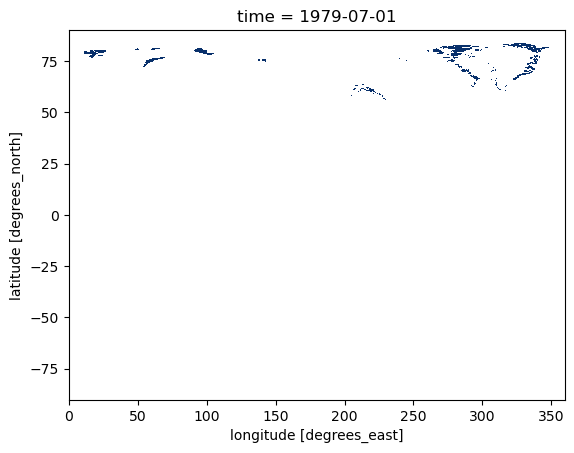

In [ ]:
templateDS = templateDS.where(july_sd_era5 > 0.1, 0)
templateDS.where(templateDS==1).plot(levels=2, cmap=cmap, add_colorbar=False)

In [ ]:
templateDS

<xarray.DataArray 'glaciermask' (latitude: 721, longitude: 1440)>
dask.array<where, shape=(721, 1440), dtype=int64, chunksize=(253, 506), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    time       datetime64[ns] 1979-07-01

### variations on glacier mask

In [ ]:
from pathlib import Path
import xarray as xr
import datetime as dt
import scipy

In [ ]:
thresh = '0.5'

In [ ]:
maskdir = Path("/Users/christine/Projects/dyndowndata/working")
with xr.load_dataset(maskdir / f"glaciermask_thresh_{thresh}m.nc", engine="netcdf4") as ds:
    glaciermask = ds.glaciermask.astype(int)
glaciermask

<xarray.DataArray 'glaciermask' (latitude: 721, longitude: 1440)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
Attributes:
    title:        ERA5-gridded glacier mask for threshold=0.5 for snow water ...
    institution:  International Arctic Research Center, UAF
    source:       Python, data file version  0.9
    author:       Chris Waigl cwaigl@alaska.edu 
    history:      2024-01-03 06:31:37.565715

In [ ]:
today = dt.date.today().isoformat()
for dil in range(1, 4):
    glacier_out = glaciermask.astype(int).copy()
    glaciermask_expand = scipy.ndimage.binary_dilation(glaciermask.data, iterations=dil)
    glacier_out[:] = glaciermask_expand
    glacier_out.attrs['title'] = f"glaciermask for ERA5 - {thresh}m July snow depth, dilated by {dil} pixels to catch all glaciated areas"
    glacier_out.attrs['history'] = today
    glacier_out.to_netcdf(outdir / f"glaciermask_thresh_{thresh}m_dilate{dil}.nc", 
        engine='netcdf4', encoding={
        'glaciermask':{'zlib': True,'complevel': 2}})


    

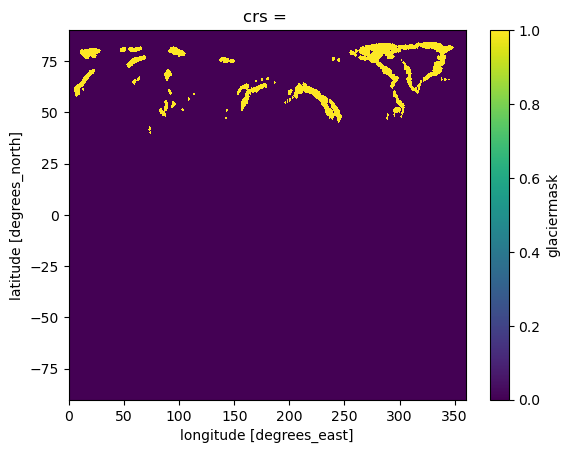

In [ ]:
glacier_out.plot()

In [ ]:
glaciermask_expand = scipy.ndimage.binary_dilation(glaciermask.data, iterations=3)
glaciermask_expand

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [ ]:
glaciermask[:] = glaciermask_expand
glaciermask

<xarray.DataArray 'glaciermask' (latitude: 721, longitude: 1440)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
    crs        <U1 ''
Attributes:
    title:        ERA5-gridded glacier mask for threshold=0.5 for snow water ...
    institution:  International Arctic Research Center, UAF
    source:       Python, data file version  0.9
    author:       Chris Waigl cwaigl@alaska.edu 
    history:      2023-12-08 07:17:50.316872

In [ ]:
glaciermask.attrs['title'] = "glaciermask for ERA5 - dilated to catch all glaciated areas"
glaciermask.attrs['history'] = '2023-03-01'

In [ ]:
outdir = Path("/Volumes/CWMobileSSD/Climate/ERA5/working")

glaciermask.to_netcdf(outdir / f"glaciermask_thresh_1m_dilate3.nc", 
        engine='netcdf4', encoding={
        'glaciermask':{'zlib': True,'complevel': 2}})